In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import ArcGIS
import time
from datetime import datetime
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('forestfires.csv')

C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


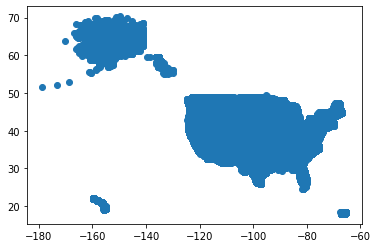

In [3]:
plt.scatter(df["LONGITUDE"], df["LATITUDE"])

In [4]:
df = df[df['STATE'] == 'CA']

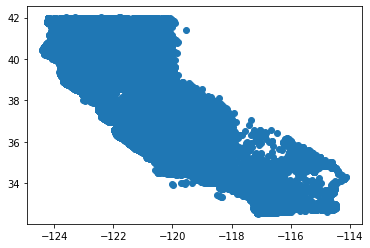

In [5]:
df = df[["FIRE_YEAR", "DISCOVERY_DOY", "DISCOVERY_TIME", "STAT_CAUSE_CODE", "STAT_CAUSE_DESCR", "CONT_DOY", "CONT_TIME", "FIRE_SIZE", "FIRE_SIZE_CLASS", "LATITUDE", "LONGITUDE", "STATE", "COUNTY"]]
len(df)
plt.scatter(df["LONGITUDE"], df["LATITUDE"])

In [6]:
stationdf = pd.read_excel('CIMIS Stations List (April18).xlsx')
stationdf.dropna(inplace=True)

In [7]:
stationdf['Disconnect_Year'] = stationdf['Disconnect']
for i in tqdm(range(len(stationdf['Disconnect_Year']))):
    if (stationdf['Disconnect'][i] == "Active"):
        stationdf['Disconnect_Year'][i] = 2021
    else:
        stationdf['Disconnect_Year'][i] = int(str(stationdf['Disconnect'][i])[:4])

stationdf['Connect_Year'] = stationdf['Connect']
for i in tqdm(range(len(stationdf['Connect_Year']))):
    stationdf['Connect_Year'][i] = int(str(stationdf['Connect'][i])[:4])

  0%|                                                                                          | 0/255 [00:00<?, ?it/s]C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
  0%|                                                                                          | 0/255 [00:00<?, ?it/s]C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCop

In [8]:
stationdf['Disconnect_doy'] = np.zeros(len(stationdf['Disconnect']))
for i in tqdm(range(len(stationdf['Disconnect']))):
    if(stationdf['Disconnect'][i] == 'Active'):
        stationdf['Disconnect_doy'][i] = 0
    else:
        stationdf['Disconnect_doy'][i] = stationdf['Disconnect'][i].timetuple().tm_yday
        
stationdf['Connect_doy'] = np.zeros(len(stationdf['Connect']))
for i in tqdm(range(len(stationdf['Connect']))):
    stationdf['Connect_doy'][i] = datetime.strptime(str(stationdf['Connect'][i]), '%Y-%m-%d %H:%M:%S').timetuple().tm_yday

  0%|                                                                                          | 0/255 [00:00<?, ?it/s]C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
  0%|                                                                                          | 0/255 [00:00<?, ?it/s]C:\Users\hkthe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCop

In [26]:
def closest(firedf, stationdf):
    closeststations = []
    for i in tqdm(range(1880465)):
        distances = []
        try:
            for j in range(len(stationdf)):
                if (int(firedf['FIRE_YEAR'][i]) > int(stationdf['Disconnect_Year'][j])):
                    distances.append(1000000000.0)
                elif (int(firedf['FIRE_YEAR'][i]) < int(stationdf['Connect_Year'][j])):
                    distances.append(1000000000.0)
                elif (int(firedf['FIRE_YEAR'][i]) == int(stationdf['Disconnect_Year'][j])):
                    if (int(firedf['DISCOVERY_DOY'][i]) >= int(stationdf['Disconnect_doy'][j])):
                        distances.append(1000000000.0)
                elif (int(firedf['FIRE_YEAR'][i]) == int(stationdf['Connect_Year'][j])):
                    if (int(firedf['DISCOVERY_DOY'][i]) <= int(stationdf['Connect_doy'][j])):
                        distances.append(1000000000.0)
                else:
                    distances.append(np.sqrt(((firedf['LATITUDE'][i] - stationdf['Latitude'][j])**2)+((firedf['LONGITUDE'][i] - stationdf['Longitude'][j])**2)))
        except:
            continue
        closeststations.append(distances.index(min(distances)) + 1)
    return closeststations
closeststations = closest(df, stationdf)

100%|█████████████████████████████████████████████████████████████████████| 1880465/1880465 [1:01:38<00:00, 508.49it/s]


In [30]:
df['Closest_stations'] = closeststations
index = []
for i in range(len(df)):
    index.append(i)
df['index'] = index
df = df.set_index('index')

In [31]:
df.to_pickle("./closeststations.pkl")